In this article we have a first look into the first set of filtered callsets.  We count the number of variants in each, look at variants' positions and the corresponding alignment at that position.

In [27]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import synapseclient
import synapseutils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Working locally
### Getting callsets

In [2]:
syn = synapseclient.login()

Welcome, Attila Jones!



In [3]:
e = synapseutils.sync.syncFromSynapse(syn, 'syn21897893', path='/big/results/bsm/calls/filtered')
fpaths = [f.path for f in e]
fpaths[:2]

['/big/results/bsm/calls/filtered/MSSM_106_brain.ploidy_50.filtered.vcf',
 '/big/results/bsm/calls/filtered/MSSM_109_brain.ploidy_50.filtered.vcf']

In [11]:
%%bash
cd /home/attila/projects/bsm/results/2020-06-05-filtered-callsets/filtered
for f in *vcf; do
echo -ne "$f\t"
bcftools view -H $f | wc -l
done | sed 's/.ploidy_50.filtered.vcf//' > varcounts.tsv

Text(0.5, 1.0, '# Somatic Variants')

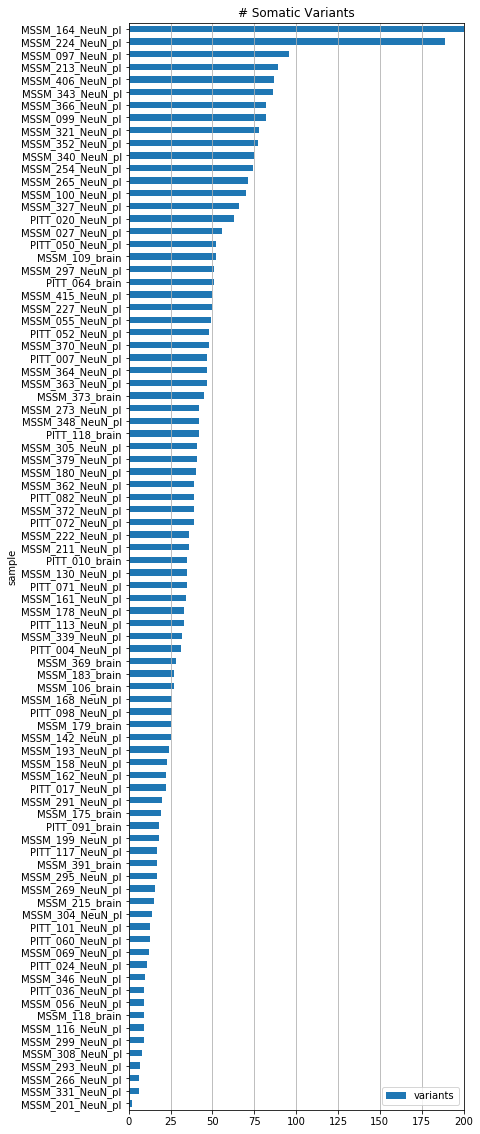

In [40]:
vcounts = pd.read_csv('/big/results/bsm/calls/filtered/varcounts.tsv', sep='\t', names=['sample', 'variants'], index_col='sample')
fig, ax = plt.subplots(figsize=(6, 20))
vcounts.sort_values(by='variants').plot(kind='barh', ax=ax)
ax.set_xlim([0, 200])
ax.grid(axis='x')
ax.set_title('# Somatic Variants')

In [37]:
vcounts.sort_values(by='variants', ascending=False).head()

,variants
sample,
MSSM_164_NeuN_pl,28110
MSSM_224_NeuN_pl,189
MSSM_097_NeuN_pl,96
MSSM_213_NeuN_pl,89
MSSM_406_NeuN_pl,87


The total number of variants excluding MSSM_164_NeuN_pl:

In [43]:
vcounts.sum() - vcounts.loc['MSSM_164_NeuN_pl', :]

variants    3301
dtype: int64

### Getting variants' positions
Let's look at the 27 variants in the MSSM_106 callset! 

In [5]:
%%bash
cd /home/attila/projects/bsm/results/2020-06-05-filtered-callsets/
vcf=MSSM_106_brain.ploidy_50.filtered-epigen.vcf
bcftools view -H $vcf | cut -f1-2

1	43788142
1	82063741
1	166060224
2	283678
2	99427525
2	112425551
2	203909037
2	227287453
4	76273821
4	139540924
6	40164483
6	143541413
9	3374188
10	33474609
10	52554008
10	126238172
12	11925758
12	46471131
12	58483907
12	83652663
12	130493454
15	61039233
16	1537659
16	4509189
16	64236891
19	24279784
22	43977690


## Working on Ada

Below I will demonstrate the following operatons:
1. start an SSH session on Ada
1. get position of variants from a VCF
1. view variants in the corresponding BAM file

### Connecting to Ada

```
[local machine]$ ssh <username>@ada.1470mad.mssm.edu
```

### Getting positions from a VCF
Filtered callsets are to be found here in `/projects/bsm/attila/results/2020-06-05-filtered-callsets`.  To look at the positions of the callset for MSSM_106_NeuN_pl sample:

```
[Ada]$ vcfdir=/projects/bsm/attila/results/2020-06-05-filtered-callsets
[Ada]$ vcf=$vcfdir/MSSM_106_brain.ploidy_50.filtered.vcf
[Ada]$ bcftools view -H $vcf | cut -f1-2
1	43788142
1	82063741
[...]
22	43977690
```

### Viewing variants in a BAM file
This is done with the script `viewvar`. Its usage is given by the `-h` switch:

In [6]:
%%bash
viewvar -h

viewvar [-l|-c|-h] chr pos bam


The `-l` switch places the variant at the left edge of the alignment view, whereas the `-c` switch centers the variant (this is the default behavior so the `-c` may be omitted).

Now let's look at the second and last variant of the VCF!  These are (chrom pos):

* 1 82063741
* 22 43977690

```
[local machine]$ ssh username@ada.1470mad.mssm.edu
[Ada]$ bam=/projects/bsm/alignments/MSSM_106/MSSM_106_NeuN_pl.bam
[Ada]$ viewvar 1 82063741 $bam | less
[Ada]$ viewvar 22 43977690 $bam | less
```

The output should be this...

In [7]:
%%bash
cd ~/projects/bsm/results/2020-06-05-filtered-callsets/varviews
cat MSSM_106_NeuN_pl-1_82063741

1:82063741 in /projects/bsm/alignments/MSSM_106/MSSM_106_NeuN_pl.bam

82063701  82063711  82063721  82063731  |8|2063741  82063751  82063761            
CCACCTATCTTTGGTTGAAGTCTGCCTCCAGAGGTAACAA|C|TGTAGTGTACTTCTGGTTTGCA*TTTTTTGGTAAACTGA
........................................|.|...................... ................
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|,|,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,
,.......................................|.|......................*................
, ............................A.........|.|......................*................
.... ,,g,,,,,,,,,,,,g,g,,,,,,,,,,,,,g,,,|,|,,,,,,,,,,,,,g,,g,,,,,*,,,,,,,,,,,,,,,,
.....  .................................|.|......................*................
,,,,,, .................................|.|......................*................
....... ................................|.|......................*................
,,,,,,,,,    ...........................|.|......................*................
..........       

...and this

In [8]:
%%bash
cd ~/projects/bsm/results/2020-06-05-filtered-callsets/varviews
cat MSSM_106_NeuN_pl-22_43977690

22:43977690 in /projects/bsm/alignments/MSSM_106/MSSM_106_NeuN_pl.bam

 43977651  43977661  43977671  43977681 | |43977691  43977701  43977711           
CACAGCTGCAGAGCCGCCTTGCACAGGCTCTGCGTCGGGT|C|GGCTTGCATGATGGAGACACCAAGGAAAAGGACAATCAA
........................................|.|.......................................
,,,,,,,,a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|,|,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,cc
,,,.....................................|.|.......................................
........................................|.|.......................................
.... ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|,|,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
......,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|,|,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,, ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|,|,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,, ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,|,|,,,,,,,,,,c,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.........   ............................|.|.......................................
,,,,,,,,,    ,,,

In [9]:
%connect_info

{
  "shell_port": 40461,
  "iopub_port": 47589,
  "stdin_port": 48405,
  "control_port": 44489,
  "hb_port": 36149,
  "ip": "127.0.0.1",
  "key": "77da5fc3-7710d316bac89c2c729f78a0",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-430d14b1-285c-4da2-b56e-bdc2fc098a18.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
